# BEE 4750 Homework 2: Systems Modeling and Simulation

**Name**: Tis Boham, Matthew Hutchinson, Cella Schnabel

**ID**:

> **Due Date**
>
> Thursday, 09/19/24, 9:00pm

## Overview

### Instructions

-   Problem 1 asks you to derive a model for water quality in a river
    system and use this model to check for regulatory compliance.
-   Problem 2 asks you to explore the dynamics and equilibrium stability
    of the shallow lake model under a particular set of parameter
    values.
-   Problem 3 (5750 only) asks you to modify the lake eutrophication
    example from Lecture 04 to account for atmospheric deposition.

### Load Environment

The following code loads the environment and makes sure all needed
packages are installed. This should be at the start of most Julia
scripts.

In [2]:
import Pkg
Pkg.activate(@__DIR__)
Pkg.instantiate()

  Activating project at `~/Desktop/BEE4750/hw/hw2-hutch-s-team`


In [3]:
using Plots
using LaTeXStrings
using CSV
using DataFrames
using Roots

## Problems (Total: 50/60 Points)

### Problem 1 (25 points)

A river which flows at 10 km/d is receiving discharges of wastewater
contaminated with CRUD from two sources which are 15 km apart, as shown
in the Figure below. CRUD decays exponentially in the river at a rate of
0.36 $\mathrm{d}^{-1}$.

<figure>
<img src="attachment:figures/river_diagram.png"
alt="Schematic of the river system in Problem 1" />
<figcaption aria-hidden="true">Schematic of the river system in Problem
1</figcaption>
</figure>

**In this problem**:

-   Assuming steady-state conditions, derive a model for the
    concentration of CRUD downriver by solving the appropriate
    differential equation(s) analytically.
-   Determine if the system in compliance with a regulatory limit of 2.5
    kg/(1000 m$^3$).

**Problem 1 Answer**

For a steady state well mixed system, concentration can be defined by the following equation: 

$C = C_0*e^{kt}$ 

In this case, there are two entry streams to consider, which start at different distances. If the distance is less than 15 km, the concentration only depends on the first entry stream. We find the concentration to be:

$Concentration=C_1*e^{(k*d/10)} \\$

Assuming $d=rt$ with $r=10km/day$

Where

$\\C_1= (Q_{River}*C_{River}+Q_{Crud_1}*C_{Crud_1})/(Q_{River}+Q_{Crud_1})=1.6724\ \\$ 

so

$Concentration=1.6724*e^{(-0.36*d/10)}$ 

It is more complicated to find concentration in distances larger than 15 km, because the CRUD decays exponentially. We must have two terms: one of the river concentration which has began decaying multiplied by the river rate and another with the inlet CRUD concentration multiplied by the rate of the river: $\\$ 

$Concentration=(Q_{River}*C_1*e^{(k*d/10)}+Q_{Crud_2}*C_{Crud_2}*e^{(k*(d-15)/10)})/(Q_{River}+Q_{Crud_2})\\$

$Concentration=(250*1.6724*e^{(k*d/10)}+420*e^{(k*(d-15)/10)})/310$

Below, our code calculates the concentration of CRUD in the stream at points from 0km to 50km, using one of our two equations above. A function determines which equation to use based on downstream position, and then calculates the concentration of CRUD. Finally, the code plots all of these collected values to show the concentration of the river at all locations downstream. 

2.14 kg/1000m^3 is the max concentration, so the system is in compliance with the regulatory limit.

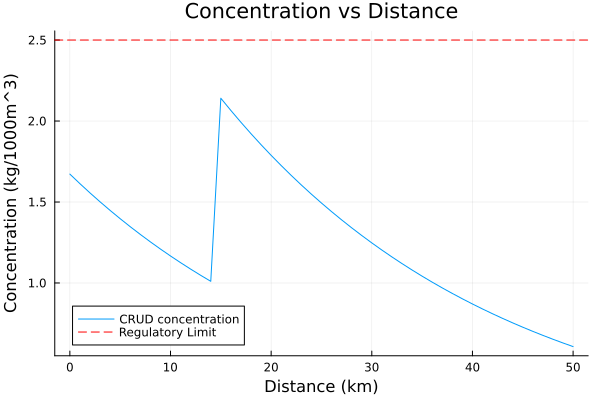

In [4]:
function concentration(d)
    if d < 15
        c= 1.6724*(ℯ^(-0.36*(d/10)))
    else
        c=(1.6724*(ℯ^(-0.36*(d/10)))*250+420*(ℯ^(-0.36*(d-15)/10)))/310
    end
    return c
end

d_values=0:1:50
c_values= [concentration(d) for d in d_values]
max_concentration = maximum(c_values)
print(string(round(max_concentration, digits=2)) * " kg/1000m^3 " * "is the max concentration, so the system is in compliance with the regulatory limit.")
plot(d_values, c_values, xlabel="Distance (km)", ylabel="Concentration (kg/1000m^3)",
     label = "CRUD concentration", title="Concentration vs Distance", legend=true)
hline!([2.5], linestyle=:dash, color=:red, label="Regulatory Limit")

According to our model, we have determined that the system is in compliance with the regulatory limit. We made this easy to visualize by plotting a line at the regulatory limit. This line is above our CRUD concentration at all locations.

### Problem 2 (25 points)


**In this problem**:

-   Make an initial conditions plot for the model dynamics for $b=0.5$,
    $q=1.5$, $y_t=0$, and $a_t=0$ for $t=0, \ldots, 30$. What are the
    equilibria? What can you say about the resilience of the system?

    > **Finding equilibria**
    >
    > Use [`Roots.jl`](https://juliamath.github.io/Roots.jl/stable/) to
    > find the equilibria by solving for values where $X_{t+1} = X_t$.
    > For example, if you have functions `X_outflow(X,b)` and
    > `X_recycling(X,q)`, you could create a function
    > `X_delta(x, a) = a + X_recycling(x) - X_outflow(x)` and call
    > `Roots.find_zero(x -> X_delta(x, a), x₀)`, where `x₀` is an
    > initial value for the search (you might need to use your plot to
    > find values for `x₀` near each of the “true” equilibria).

-   Repeat the analysis with $a_t=0.02$ for all $t$. What are the new
    equilibria? How have the dynamics and resilience of the system
    changed?

Our code below is almost exactly the same as that from lecture. It creates 3 functions, 2 that represent the equations for P cycling and P out, and a third that will print the system dynamics for many different initial conditions. This third function iterates through $X_t$ over the time period of 0 to 30 days. It does this for many different initial $X_{t}$ values, from 0 to 2.5. All of these lines are then plotted together to show how the system varies with different initial conditions.

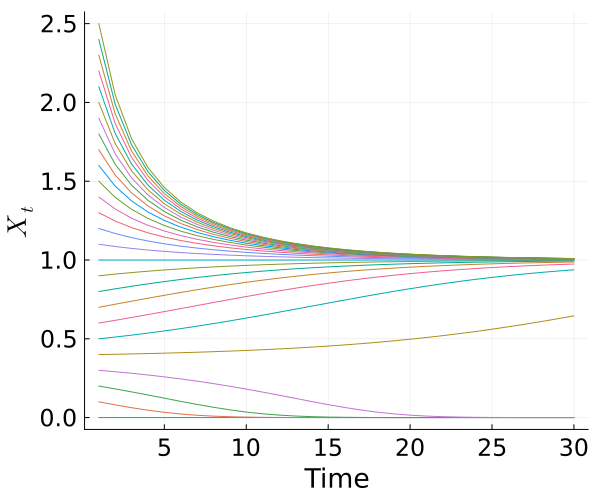

In [18]:
#use the same code from lecture to make the initial conditions plot
#BUT, change the values of b and q
# define functions for lake recycling and outflows
lake_P_cycling(x, q) = x.^q ./ (1 .+ x.^q);
lake_P_out(x, b) = b .* x;

T = 30
X_vals = collect(0.0:0.1:2.5)
function simulate_lake_P(X_ic, T, b, q, a, y)
    X = zeros(T)
    X[1] = X_ic
    for t = 2:T
        X[t] = X[t-1] .+ a[t] .+ y[t].+ lake_P_cycling(X[t-1], q) .- lake_P_out(X[t-1], b)
    end
    return X
end
#change the values of b and q
X = map(x -> simulate_lake_P(x, T, 0.5, 1.5, zeros(T), zeros(T)), X_vals)
p_noinflow = plot(X, label=false, ylabel=L"X_t", xlabel="Time", guidefontsize=18, tickfontsize=16, size=(600, 500))




We consider the shallow lake model from class:

$$
\begin{aligned}
X_{t+1} &= X_t + a_t + y_t + \frac{X_t^q}{1 + X_t^q} - bX_t,                (1) \\
y_t &\sim \text{LogNormal}(\mu, \sigma^2),
\end{aligned}
$$

where:

-   $X_t$ is the lake phosphorous (P) concentration at time $t$;
-   $a_t$ is the point-source P release at time $t$;
-   $y_t$ is the non-point-source P release at time $t$, which is
    treated as random from a LogNormal distribution with mean $\mu$ and
    standard deviation $\sigma$;
-   $b$ is the linear rate of P outflow;
-   $q$ is a parameter influencing the rate of P recycling from the
    sediment.


Below is our version of the provided code to solve for the equilibria. We define our equations for P cycling and P outflow, and then set the constant variables. We then make our X_delta function; a simplified version of equation (1). This is used by the next function 'find_zeros' to determine the equilibria of the system. From our above graph, we assumed the zeroes were about 0 and 1. 
We used these values as our initial guesses in the code and found that the outputs of 0 and 1 are in fact the zeroes of the system. 

For this model, we notice that for $X_0$ concentrations at 0.3 or below, the system is resilient and converges to 0.0, while for $X_0$ greater than 0.3, we find a stable phosphorous concentration of 1.0. Here we define resilient as zero net phosphorus.

In [5]:
#Find the equilibria

#use the same function as the one from the question
lake_P_cycling(x, q) = x^q / (1 + x^q);
lake_P_out(x, b) = b * x;
#a is alpha here, which is set to 0.00
a = 0;
q = 1.5;
b = 0.5;
#call the fucntions using 'x' instead of X[] so it's not iterative anymore
X_delta(x) = a+ lake_P_cycling(x,q) - lake_P_out(x,b);
#when we set the guess at 0, we get the zero equilibrium
show(Roots.find_zero(x->X_delta(x), 0))

#and when we set it to around 1, we get the 1 equilibrium
Roots.find_zero(x->X_delta(x), 1.1)


0.0

1.0

Here we run our above code again for Initial conditions plotting, but change the alpha value to 0.02.

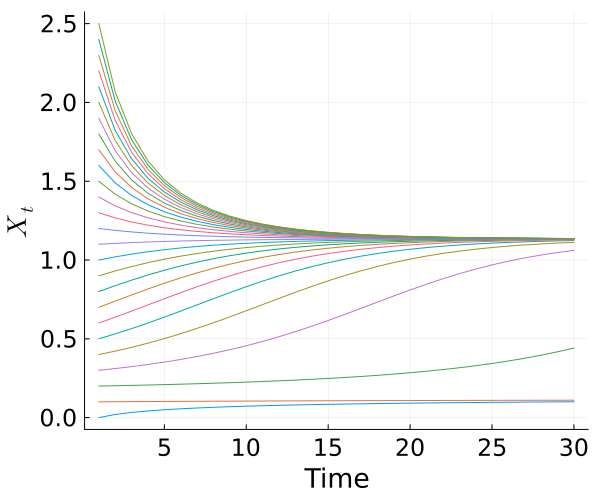

In [6]:
#use the same code from lecture to make the initial conditions plot
#CHANGE alpha value from 0 to 0.02
# define functions for lake recycling and outflows
lake_P_cycling(x, q) = x.^q ./ (1 .+ x.^q);
lake_P_out(x, b) = b .* x;

T = 30
X_vals = collect(0.0:0.1:2.5)
function simulate_lake_P(X_ic, T, b, q, a, y)
    X = zeros(T)
    X[1] = X_ic
    for t = 2:T
        X[t] = X[t-1] .+ a[t] .+ y[t].+ lake_P_cycling(X[t-1], q) .- lake_P_out(X[t-1], b)
    end
    return X
end
#change the values of b and q
a_1 = fill(0.02,T)
X = map(x -> simulate_lake_P(x, T, 0.5, 1.5, zeros(T), a_1), X_vals)
p_noinflow = plot(X, label=false, ylabel=L"X_t", xlabel="Time", guidefontsize=18, tickfontsize=16, size=(600, 500))

We then test the 0.02 equilibria for this case. The above plot appears to have equilibria at 0.1 and 1.1...

In [48]:
#Find the equilibria

#use the same function as the one from the question
lake_P_cycling(x, q) = x^q / (1 + x^q);
lake_P_out(x, b) = b * x;
#a is alpha here, which is set to 0.00
a = 0.02;
q = 1.5;
b = 0.5;
#call the fucntions using 'x' instead of X[] so it's not iterative anymore
X_delta(x) = a + lake_P_cycling(x,q) - lake_P_out(x,b);
#when we set the guess at 0, we get the zero equilibrium
show(Roots.find_zero(x->X_delta(x), 0))

#and when we set it to around 1, we get the 1 equilibrium
Roots.find_zero(x->X_delta(x), 1)


0.1162444196607475

1.1341008852434813

From our initial conditions plot where $b = 0.5, q = 1.5, y_t = 0, \text{ and } a_t = 0.02 \text{ for } t = 0, ..., 30$, we find the equilibria to be 1.134 and 0.1162 by noticing when $X_t$ stops changing as a function of time (where phosphorous concentration in = phosphorous concentration out). We calculate $X_t$ the same way as before using the new $a_t$ value of 0.02.

For this model, we notice that for $X_0$ concentrations at 0.3 or below, the system converges to 0.1162, while for $X_0$ greater than 0.3, we find a stable phosphorous concentration of 1.134. Using the same definition of resilience, neither of these stable equilibria are resilient, and therefore in this model there are no resilient solutions. The split in the data remains at $X_0$ = 0.3, though the equilibrium values change. 

### Problem 3 (10 points)

**This problem is only required for students in BEE 5750**.

Consider the lake eutrophication example from [Lecture
04](https://viveks.me/environmental-systems-analysis/slides/lecture03-1-eutrophication-modeling.html#/title-slide).
Suppose that phosphorous is also atmospherically deposited onto the lake
surface at a rate of
$1.6 \times 10^{-4} \mathrm{kg/(yr} \cdot \mathrm{m}^2)$, which is then
instantly mixed into the lake. Derive a model for the lake phosphorous
concentration and find the maximum allowable point source phosphorous
loading if the goal is to keep lake concentrations below 0.02 mg/L.

## References

List any external references consulted, including classmates.